In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Here reference level $C_{0}^{\alpha}L_{0}^{1-\alpha}$ refers to a steady state variable.

The utility is given by:
\begin{equation}
    u(C_{t},L_{t}) = \begin{cases}
    \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho} \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha} \geq C_{0}^{\alpha}L_{0}^{1-\alpha} \\
    \frac{(C_{0}^{\alpha}L_{0}^{1-\alpha})^{1-\rho}}{1-\rho} - \lambda(\frac{(C_{0}^{\alpha}L_{0}^{1-\alpha})^{1-\rho}}{1-\rho} - \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho}) \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha}< C_{0}^{\alpha}L_{0}^{1-\alpha} \\
\end{cases}
\end{equation}



If we reframe this a bit to make sure all the object value is positive:
\begin{equation}
    u(C_{t},L_{t}) = \begin{cases}
    \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho} + (\lambda-1) \frac{(C_{0}^{\alpha}L_{0}^{1-\alpha})^{1-\rho}}{1-\rho}
    \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha} \geq C_{0}^{\alpha}L_{0}^{1-\alpha} \\
    \lambda \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho}
    \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha}< C_{0}^{\alpha}L_{0}^{1-\alpha} \\
    \end{cases}
\end{equation}

In [2]:
#import package
import numpy as np
from datascience import Table
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy import optimize
import time

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# import data
import pandas as pd
interestTable = pd.read_csv('return_H.csv', usecols=[1,2,3])  ## Import interest rate
mortalityTable = pd.read_csv('newmort2.csv', usecols=[1,2,3])  ## Import mortality table'
Expectation = Table.from_df(interestTable)  ## Convert readin csv file to 'table'

In [3]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [4]:
# parameter setting
ρ = 0.5 # 5?
α = 0.9
β = 1
λ = 3

Y1 = 11.9
Y2 = 3.0 # salary

θ = 0.5

# 1.1 Read csv files

In [5]:
# results from EGM
csv1 =  pd.read_csv('Model6_EGM_74-65.csv')
csv2 = pd.read_csv('Model6_EGM_64-55.csv')
# results from VFI
# csv1 =  pd.read_csv('Model2_VFI_74-65.csv')
# csv2 = pd.read_csv('Model2_VFI_64-55.csv')

Optimal_results_EGM = Table.from_df(csv1)
Optimal_results_EGM_55_63 = Table.from_df(csv2)

In [6]:
Optimal_results_EGM_55_63.show(1)

A64,R64,C64,C_un64,L64,L_un64,M64,A63,R63,C63,C_un63,L63,L_un63,M63,A62,R62,C62,C_un62,L62,L_un62,M62,A61,R61,C61,C_un61,L61,L_un61,M61,A60,R60,C60,C_un60,L60,L_un60,M60,A59,R59,C59,C_un59,L59,L_un59,M59,A58,R58,C58,C_un58,L58,L_un58,M58,A57,R57,C57,C_un57,L57,L_un57,M57,A56,R56,C56,C_un56,L56,L_un56,M56,A55,R55,C55,C_un55,L55,L_un55,M55
1,1,2.04703,2.04703,0.285714,0.0237302,-5.45297,1,1,2.6861,2.6861,0.285714,0.0304692,-4.8139,1,1,3.21231,3.21231,0.285714,0.0359204,-4.28769,1,1,3.65423,3.65423,0.285714,0.0404428,-3.84577,1,1,4.03021,4.03021,0.285714,0.0442558,-3.46979,1,1,4.3533,4.3533,0.285714,0.0475096,-3.1467,1,1,4.63317,4.63317,0.285714,0.0503125,-2.86683,1,1,4.87721,4.87721,0.285714,0.0527456,-2.62279,1,1,5.09123,5.09123,0.285714,0.0548712,-2.40877,1,1,5.27982,5.27982,0.285714,0.0567385,-2.22018


# Simulation for prospect theory

In [7]:
StartAge = 55

StartBal = 50 ## before consumption
StartRef_CL = 0 ## start reference level

Salary_before = 11.9
Salary_after = 3.0
print('StartRef_C = '+str(StartRef_CL))

age = np.arange(55,75)

StartRef_C = 0


In [8]:
Numsim = 10
np.random.seed(1)
RandomBond = np.random.choice(Expectation.column('Bond'), p = Expectation.column('Probability'), \
                 size = [Numsim,20], replace = True) ## Generate random bond return
RandomEq = np.random.choice(Expectation.column('Eq'), p = Expectation.column('Probability'), \
                 size = [Numsim,20], replace = True) ## Generate random Equity return, 1000 (individuals) * 10 (age55-64)

hide_toggle()

In [9]:
Optimal_results_EGM_55_63.show(1)

A64,R64,C64,C_un64,L64,L_un64,M64,A63,R63,C63,C_un63,L63,L_un63,M63,A62,R62,C62,C_un62,L62,L_un62,M62,A61,R61,C61,C_un61,L61,L_un61,M61,A60,R60,C60,C_un60,L60,L_un60,M60,A59,R59,C59,C_un59,L59,L_un59,M59,A58,R58,C58,C_un58,L58,L_un58,M58,A57,R57,C57,C_un57,L57,L_un57,M57,A56,R56,C56,C_un56,L56,L_un56,M56,A55,R55,C55,C_un55,L55,L_un55,M55
1,1,2.04703,2.04703,0.285714,0.0237302,-5.45297,1,1,2.6861,2.6861,0.285714,0.0304692,-4.8139,1,1,3.21231,3.21231,0.285714,0.0359204,-4.28769,1,1,3.65423,3.65423,0.285714,0.0404428,-3.84577,1,1,4.03021,4.03021,0.285714,0.0442558,-3.46979,1,1,4.3533,4.3533,0.285714,0.0475096,-3.1467,1,1,4.63317,4.63317,0.285714,0.0503125,-2.86683,1,1,4.87721,4.87721,0.285714,0.0527456,-2.62279,1,1,5.09123,5.09123,0.285714,0.0548712,-2.40877,1,1,5.27982,5.27982,0.285714,0.0567385,-2.22018


In [10]:
Optimal_results_EGM_55_63['C64']

array([2.04702653, 2.16110484, 2.27452964, ..., 8.5       , 8.5       ,
       8.5       ])

In [11]:
start_time = time.time()

title = []
for i in range(20):
    title.append("age %d"%(i+55))
Simulation_Cons = Table(np.array(title))
Simulation_Lei = Table(np.array(title))
Simulation_Bal = Table(np.array(title))

# Simulate age 55-74
for i in range(Numsim):
    Mxx = StartBal
    Ref_xx = StartRef_CL
    Cx = []
    Lx = []
    Mx = []
    for j in range(20): ## 0-9
        print(i, j)
        Mx.append(Mxx)
        interest = 1 + θ*RandomEq[i,j] + (1-θ)*RandomBond[i,j]
        if j<10:
            Interpolation_C = interpolate.Rbf(Optimal_results_EGM_55_63['M%1d'%(55+j)], 
                                              Optimal_results_EGM_55_63['R%1d'%(55+j)], 
                                              Optimal_results_EGM_55_63['C%1d'%(55+j)],
                                              kind='linear')
            Interpolation_L = interpolate.Rbf(Optimal_results_EGM_55_63['M%1d'%(55+j)], 
                                              Optimal_results_EGM_55_63['R%1d'%(55+j)], 
                                              Optimal_results_EGM_55_63['L%1d'%(55+j)],
                                              kind='linear')
            Salary = Salary_before
        else:
            Interpolation_C = interpolate.Rbf(Optimal_results_EGM['M%1d'%(55+j)], 
                                              Optimal_results_EGM['R%1d'%(55+j)],
                                              Optimal_results_EGM['C%1d'%(55+j)],
                                              kind='linear')
            Interpolation_L = interpolate.Rbf(Optimal_results_EGM['M%1d'%(55+j)], 
                                              Optimal_results_EGM['R%1d'%(55+j)], 
                                              Optimal_results_EGM['L%1d'%(55+j)],
                                              kind='linear')
            Salary = Salary_after
        Cxx = Interpolation_C(Mxx, Ref_xx) # Use past year consumption as reference level
        Lxx = Interpolation_L(Mxx, Ref_xx)
        Ref_xx = Cxx * np.power((1-α)/(α*Salary), 1-α)  ## This is a formula to evolve reference level
#         Ref_xx = np.power(Cxx,α) * np.power(Lxx,1-α)
        Cx.append(Cxx)
        Lx.append(Lxx)
        Mxx = (Mxx - Cxx + Salary*(1-Lxx)) * interest
    Simulation_Cons = Simulation_Cons.with_row(Cx)
    Simulation_Lei = Simulation_Lei.with_row(Lx)
    Simulation_Bal = Simulation_Bal.with_row(Mx)
    
print("--- %s seconds ---" % (time.time() - start_time))

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19


In [12]:


C_Percentile_25 = Simulation_Cons.percentile(25)
C_Percentile_50 = Simulation_Cons.percentile(50)
C_Percentile_75 = Simulation_Cons.percentile(75)

L_Percentile_25 = Simulation_Lei.percentile(25)
L_Percentile_50 = Simulation_Lei.percentile(50)
L_Percentile_75 = Simulation_Lei.percentile(75)

M_Percentile_25 = Simulation_Bal.percentile(25)
M_Percentile_50 = Simulation_Bal.percentile(50)
M_Percentile_75 = Simulation_Bal.percentile(75)


Text(0,0.5,'Consumption')

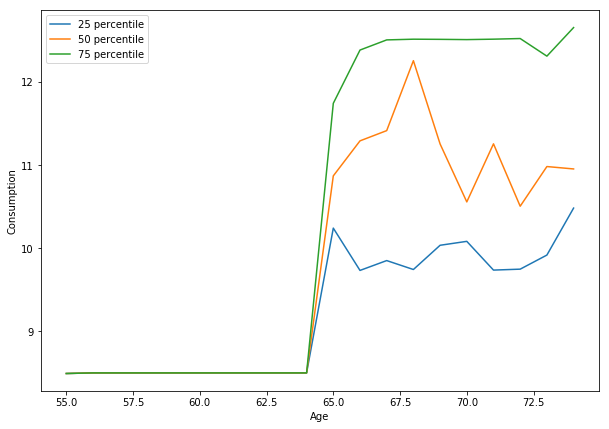

In [13]:
plt.figure(figsize=(10,7))
plt.plot(age, np.array(C_Percentile_25.row(0)), label='25 percentile')
plt.plot(age, np.array(C_Percentile_50.row(0)), label='50 percentile')
plt.plot(age, np.array(C_Percentile_75.row(0)), label='75 percentile')
plt.legend(loc='upper left')
plt.xlabel('Age')
plt.ylabel('Consumption')
# plt.ylim(0,)
# plt.savefig('Model1_cons_1000sim')

(0, 1.1)

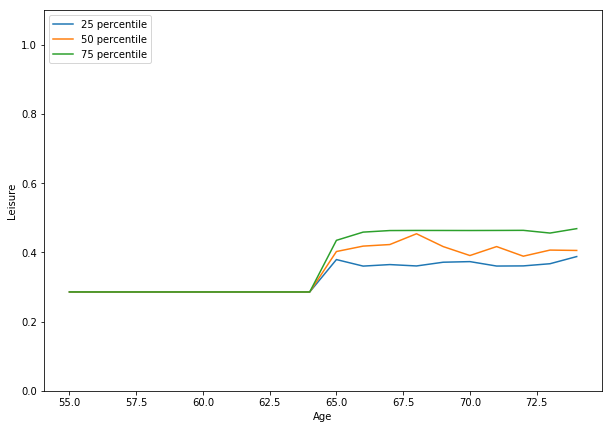

In [14]:
plt.figure(figsize=(10,7))
plt.plot(age, np.array(L_Percentile_25.row(0)), label='25 percentile')
plt.plot(age, np.array(L_Percentile_50.row(0)), label='50 percentile')
plt.plot(age, np.array(L_Percentile_75.row(0)), label='75 percentile')
plt.legend(loc='upper left')
plt.xlabel('Age')
plt.ylabel('Leisure')
plt.ylim(0, 1.1)
# plt.savefig('Model1_cons_1000sim')

Text(0,0.5,'Start-period balance')

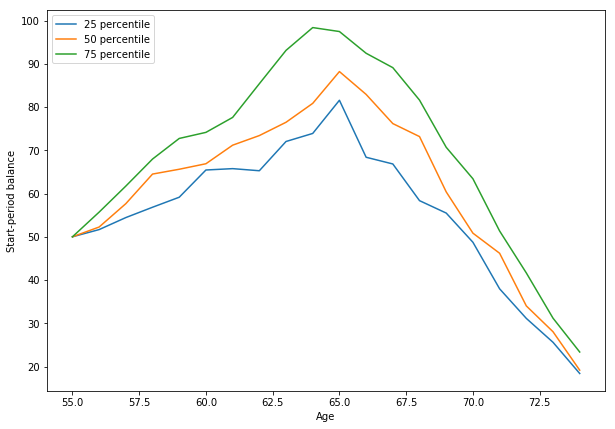

In [15]:
plt.figure(figsize=(10,7))
plt.plot(age, np.array(M_Percentile_25.row(0)), label='25 percentile')
plt.plot(age, np.array(M_Percentile_50.row(0)), label='50 percentile')
plt.plot(age, np.array(M_Percentile_75.row(0)), label='75 percentile')
plt.legend(loc='upper left')
plt.xlabel('Age')
plt.ylabel('Start-period balance')
# plt.savefig('Model1_bal_1000sim')